This notebook demonstrates taking a Nengo model, splitting it into parts that need to be run on the host (i.e. anything that is  Node) and what should be run on-chip (non-direct-mode Ensembles).  Then these two parts can be run together, synchronizing nicely between the host and the chip.

If the host code can be split into two parts, then we can also run everything separately.  We split the host code into a pre and post portion, run the pre code first, then run the chip (with the inputs gathered from the host-pre), and then take those outputs and run the host-post code.

In [54]:
%matplotlib inline
import pylab
import nengo
import nengo_normal_form
import nengo_benchmarks
import numpy as np


First, we need a function to split the Network into two parts.  We use `is_on_chip` to determine if a component (Node or Ensemble) will be on the chip; everything else is on the host.

Important note: Passthrough Nodes are hard to deal with here!  For this code, we put all passthrough nodes on the host.  If, however, we call `nengo_normal_form.convert` before this, then all passthrough nodes will be removed anyway.  It would also be possible to do a graph-spreading algorithm to put some Passthrough Nodes on-chip and some on the host, depending on the Connections.

Also, `nengo_normal_form.convert` by default collects all the decoders from a single ensemble together into one large decoder which goes into a `nengo_normal_form.DecoderNode`.  So this code will place that Node on the chip.

The `SendNode` and `ReceiveNode` will be added to the host and chip networks to form the links between the two models.

In [27]:
def is_on_chip(obj):
    '''Determine if a component should be placed on the chip or host'''
    if isinstance(obj, nengo.Ensemble):
        if isinstance(obj.neuron_type, nengo.Direct):
            return False
        else:
            return True
    elif isinstance(obj, nengo.Node):
        if isinstance(obj, nengo_normal_form.DecoderNode):
            return True
        else:
            return False
    raise Exception('Unhandled object type: %s' % obj)
    
class SendNode(nengo.Node):
    '''For communicating host->chip and chip->host'''
    def __init__(self, dimensions, target):
        self.target = target
        super(SendNode, self).__init__(self.update, size_in=dimensions, size_out=0)
    def update(self, t, x):
        self.target.receive(t, x)
        
class ReceiveNode(nengo.Node):
    '''For communicating host->chip and chip->host'''
    def __init__(self, dimensions):
        self.queue = [(0, np.zeros(dimensions))]
        self.queue_index = 0
        super(ReceiveNode, self).__init__(self.update, size_in=0, size_out=dimensions)
    def update(self, t):
        while len(self.queue)>self.queue_index+1 and self.queue[self.queue_index][0] < t:
            self.queue_index += 1
        return self.queue[self.queue_index][1]
    def receive(self, t, x):
        self.queue.append((t, x))
        
def split_host_chip(model):
    '''Split a model into code running on the host and on-chip'''
    host = nengo.Network(seed=model.seed)
    chip = nengo.Network(seed=model.seed)

    for ens in model.all_ensembles:
        if is_on_chip(ens):
            chip.ensembles.append(ens)
        else:
            host.ensembles.append(ens)
            
    for node in model.all_nodes:
        if is_on_chip(node):
            chip.nodes.append(node)
        else:
            host.nodes.append(node)
            
    for c in model.all_connections:
        if (isinstance(c.pre, nengo.Ensemble) and
                isinstance(c.post, nengo_normal_form.DecoderNode)):
            chip.connections.append(c)
        elif (isinstance(c.pre, nengo.ensemble.Neurons) and
                isinstance(c.post, nengo.Node)):
            chip.connections.append(c)
        elif (isinstance(c.pre_obj, nengo_normal_form.DecoderNode) and
                isinstance(c.post_obj, nengo.Ensemble)):
            chip.connections.append(c)

        else:
            pre_onchip = is_on_chip(c.pre_obj)
            post_onchip = is_on_chip(c.post_obj)
            if post_onchip and not pre_onchip:
                dim = c.size_out
                with chip:
                    receive = ReceiveNode(dim)
                    nengo.Connection(receive, c.post, synapse=None)
                with host:
                    send = SendNode(dim, receive)
                    nengo.Connection(c.pre, send, 
                                     function=c.function,
                                     solver=c.solver,
                                     eval_points=c.eval_points,
                                     scale_eval_points=c.scale_eval_points,
                                     synapse=c.synapse,
                                     transform=c.transform)
            elif pre_onchip and not post_onchip:
                dim = c.size_out
                with host:
                    receive = ReceiveNode(dim)
                    nengo.Connection(receive, c.post, synapse=None)
                with chip:
                    send = SendNode(dim, receive)
                    nengo.Connection(c.pre, send, 
                                     function=c.function,
                                     solver=c.solver,
                                     eval_points=c.eval_points,
                                     scale_eval_points=c.scale_eval_points,
                                     synapse=c.synapse,
                                     transform=c.transform)
            elif not pre_onchip and not post_onchip:
                host.connections.append(c)
            else:
                raise Exception('Unhandled Connection %s' % c)    
    return host, chip
                


Let's create a model to test with.  We're setting seeds to make sure the Ensembles get the same seed value regardless of how we reorganize the network (`nengo_normal_form.seeds` uses the same algorithm as core `nengo`) 

In [55]:
def generate_test_model():
    np.random.seed(1)
    model = nengo_benchmarks.CircularConvolution().make_model(D=2)
    rng = np.random.RandomState(seed=2)
    nengo_normal_form.seeds.assign_seeds(model, rng=rng)
    return model

First, let's run it normally

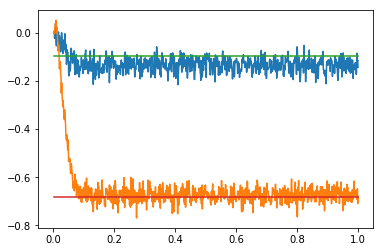

In [57]:
model = generate_test_model()

sim = nengo.Simulator(model, progress_bar=None)
sim.run(1.0)

for p in model.probes:
    pylab.plot(sim.trange(), sim.data[p])

Now let's switch to normal form.  Notice that, by default, this converts Probes into Nodes, so the plotting code is slightly different.

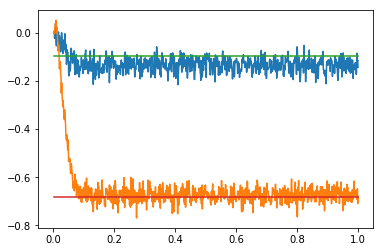

In [58]:
model = generate_test_model()
model_normal, probes = nengo_normal_form.convert(model)
sim = nengo.Simulator(model_normal, progress_bar=None)
sim.run(1.0)

for p, node in probes.items():
    pylab.plot(sim.trange(), node.data)

Now let's split things apart and run them in lock-step

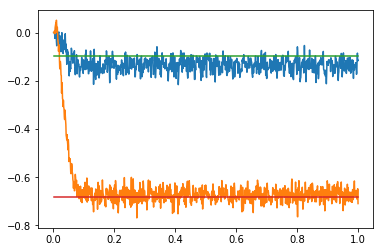

In [63]:
model = generate_test_model()
model_normal, probes = nengo_normal_form.convert(model)
host, chip = split_host_chip(model_normal)

sim_host = nengo.Simulator(host, progress_bar=None)
sim_chip = nengo.Simulator(chip, progress_bar=None)

for i in range(int(1.0/sim_host.dt)):
    sim_host.step()
    sim_chip.step()

for p, node in probes.items():
    pylab.plot(sim_host.trange(), node.data)

Now we want to split the host code into two parts: one part that's all the inputs to the model, and one part that's all the outputs from the model.  We can't always do this (as inputs may depend on outputs), but if we can, we can precompute the inputs, give them to the chip all at once, and then take the outputs after the chip has finished.

We implement this as a simple graph-flooding algorithm, starting at the SendNodes in the host, and spreading.  If we hit a ReceiveNode, then inputs do depend on outputs, but if we don't then we have a nice separation between pre and post.

In [51]:
def extract_pre_from_host(host_model):
    pre = nengo.Network()
    inputs = {}
    outputs = {}
    queue = []
    for n in host_model.nodes[:]:
        inputs[n] = []
        outputs[n] = []
        if isinstance(n, SendNode):
            host_model.nodes.remove(n)
            pre.nodes.append(n)
            queue.append(n)
    for c in host_model.connections:
        inputs[c.post_obj].append(c)
        outputs[c.pre_obj].append(c)

    while len(queue) > 0:
        n = queue.pop()
        for c in inputs[n]:
            if c not in host_model.connections:
                continue
            host_model.connections.remove(c)
            pre.connections.append(c)
            if c.pre_obj in host_model.nodes:
                if isinstance(c.pre_obj, ReceiveNode):
                    raise Exception('Cannot precompute input, as it is dependent on output')
                host_model.nodes.remove(c.pre_obj)
                pre.nodes.append(c.pre_obj)
                queue.append(c.pre_obj)
        for c in outputs[n]:
            if c not in host_model.connections:
                continue
            host_model.connections.remove(c)
            pre.connections.append(c)
            if c.post_obj in host_model.nodes:
                if isinstance(c.post_obj, ReceiveNode):
                    raise Exception('Cannot precompute input, as it is dependent on output')
                host_model.nodes.remove(c.post_obj)
                pre.nodes.append(c.post_obj)
                queue.append(c.post_obj)

    return pre



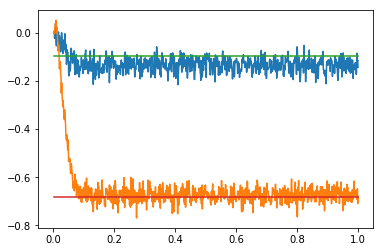

In [62]:
model = generate_test_model()
model_normal, probes = nengo_normal_form.convert(model)
post, chip = split_host_chip(model_normal)

pre = extract_pre_from_host(post)

sim_pre = nengo.Simulator(pre, progress_bar=None)
sim_pre.run(1.0)
sim_chip = nengo.Simulator(chip, progress_bar=None)
sim_chip.run(1.0)
sim_post = nengo.Simulator(post, progress_bar=None)
sim_post.run(1.0)

for p, node in probes.items():
    pylab.plot(sim_post.trange(), node.data)